In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import timm
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os
from torch.cuda.amp import GradScaler, autocast

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DenseNet uses 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Reduce the training set size for faster experimentation
train_size = int(0.1 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# DenseNet Model Setup with `timm`
model_name = 'densenet'
model = timm.create_model('densenet121', pretrained=True, num_classes=1)
model = model.to(device)

# Loss, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = GradScaler()

# Training, Validation, and Testing
num_epochs = 5
history_densenet = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_densenet['train_losses'].append(running_loss / len(train_loader))
    history_densenet['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_densenet['val_losses'].append(val_running_loss / len(val_loader))
    history_densenet['val_accuracies'].append(val_correct / len(val_loader.dataset))

    # Testing after each epoch
    test_running_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == labels).sum().item()

    history_densenet['test_losses'].append(test_running_loss / len(test_loader))
    history_densenet['test_accuracies'].append(test_correct / len(test_loader.dataset))

    print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {history_densenet["train_losses"][-1]:.4f}, Val Loss: {history_densenet["val_losses"][-1]:.4f}, Test Loss: {history_densenet["test_losses"][-1]:.4f}, Train Acc: {history_densenet["train_accuracies"][-1]:.4f}, Val Acc: {history_densenet["val_accuracies"][-1]:.4f}, Test Acc: {history_densenet["test_accuracies"][-1]:.4f}')

    scheduler.step()

# Save the model and history
model_path = f'/content/drive/MyDrive/{model_name}_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/{model_name}_history.pth'
torch.save(history_densenet, history_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


densenet Epoch 1/5, Train Loss: 0.7152, Val Loss: 0.6825, Test Loss: 0.6881, Train Acc: 0.5443, Val Acc: 0.5000, Test Acc: 0.5100
densenet Epoch 2/5, Train Loss: 0.4574, Val Loss: 0.5607, Test Loss: 0.6156, Train Acc: 0.8481, Val Acc: 0.7143, Test Acc: 0.7400
densenet Epoch 3/5, Train Loss: 0.3176, Val Loss: 0.5429, Test Loss: 0.6230, Train Acc: 0.9241, Val Acc: 0.7551, Test Acc: 0.7900
densenet Epoch 4/5, Train Loss: 0.2687, Val Loss: 0.5232, Test Loss: 0.6207, Train Acc: 0.9494, Val Acc: 0.7551, Test Acc: 0.7100
densenet Epoch 5/5, Train Loss: 0.2603, Val Loss: 0.5281, Test Loss: 0.6190, Train Acc: 0.9367, Val Acc: 0.7449, Test Acc: 0.6800


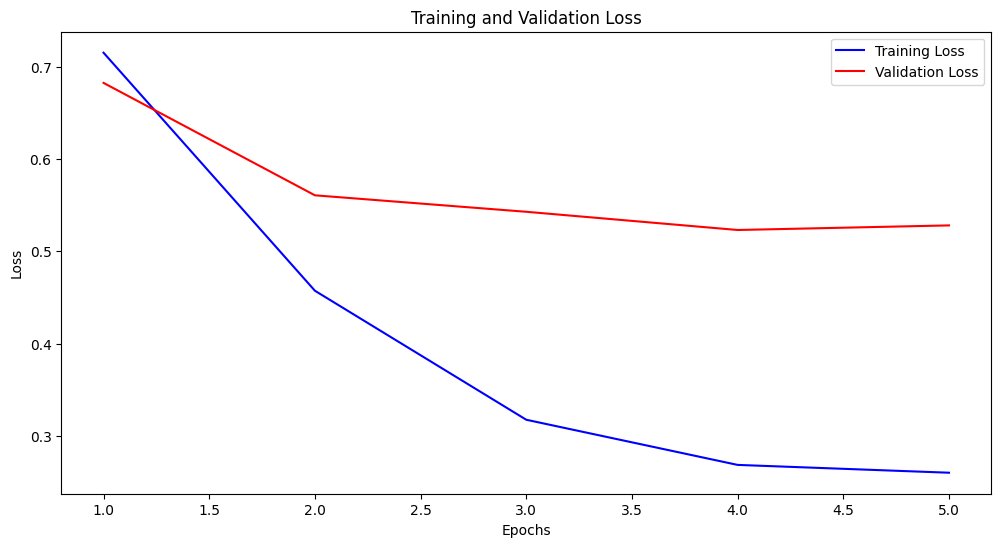

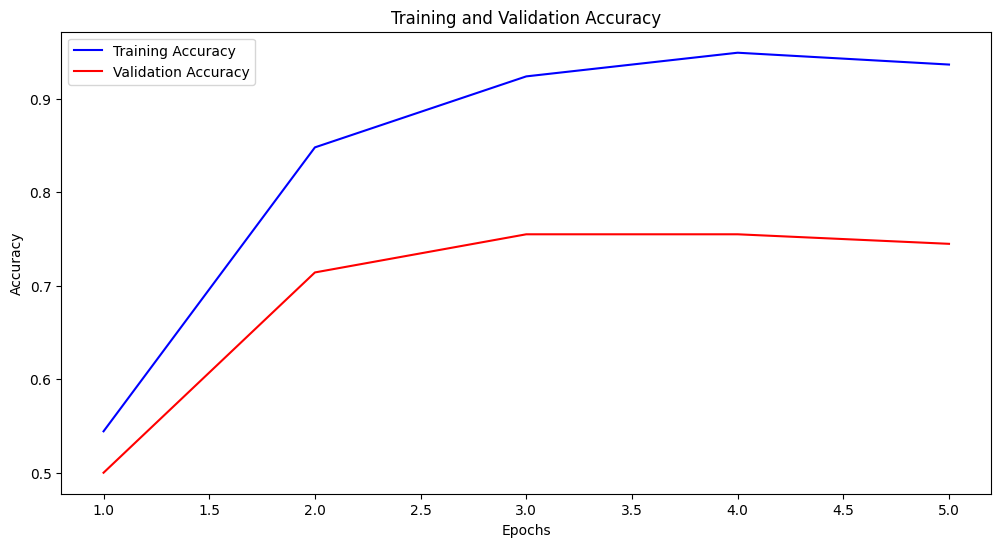

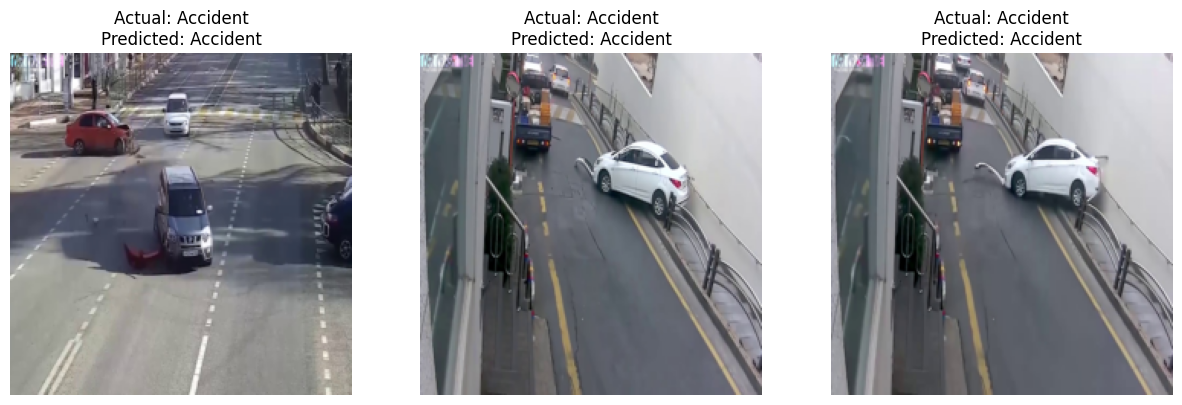

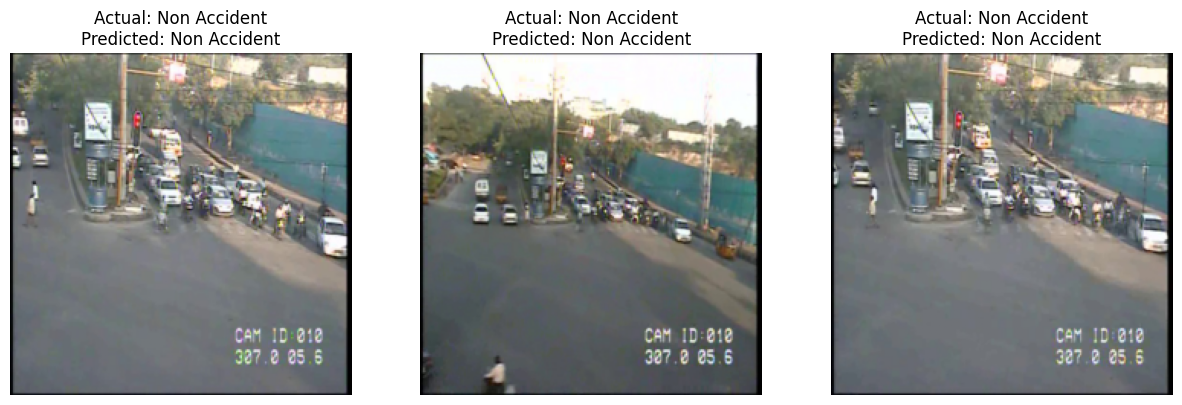

Classification Report:
              precision    recall  f1-score   support

Non Accident       0.81      0.67      0.74        52
    Accident       0.69      0.83      0.75        46

    accuracy                           0.74        98
   macro avg       0.75      0.75      0.74        98
weighted avg       0.76      0.74      0.74        98



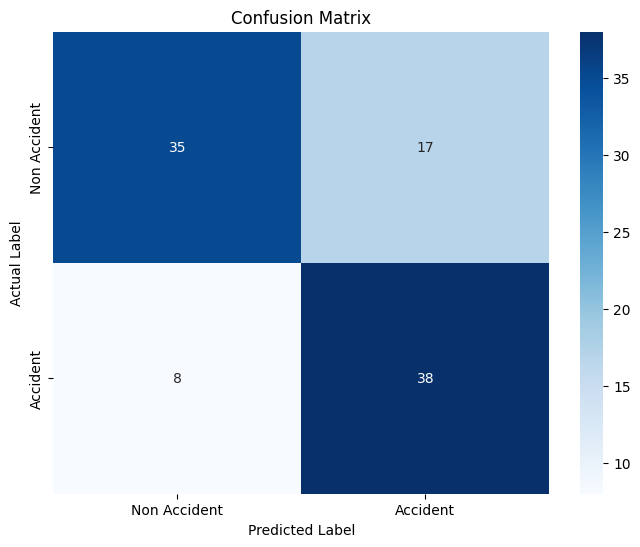

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Load the history for plotting
history_densenet = torch.load('/content/drive/MyDrive/densenet_history.pth')

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_densenet)

# Visualize Correct Predictions on the Validation Set
def visualize_correct_predictions(model, val_loader, num_images=3):
    model.eval()
    accident_images = []
    non_accident_images = []
    accident_indices = set()
    non_accident_indices = set()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                if preds[i] == 1 and labels[i] == 1 and len(accident_images) < num_images:
                    if i not in accident_indices:  # Ensure this image hasn't been used before
                        accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                        accident_indices.add(i)
                elif preds[i] == 0 and labels[i] == 0 and len(non_accident_images) < num_images:
                    if i not in non_accident_indices:  # Ensure this image hasn't been used before
                        non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                        non_accident_indices.add(i)

                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break

            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Correct Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Correct Non Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model for visualization
model_densenet = timm.create_model('densenet121', pretrained=False, num_classes=1)
model_densenet.load_state_dict(torch.load('/content/drive/MyDrive/densenet_finetuned.pth'))
model_densenet = model_densenet.to(device)

# Visualize correct predictions
visualize_correct_predictions(model_densenet, val_loader, num_images=3)

# Function to get predictions and true labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Generate Classification Report and Confusion Matrix
preds, labels = get_predictions_and_labels(model_densenet, val_loader)

# Classification Report
print("Classification Report:")
print(classification_report(labels, preds, target_names=['Non Accident', 'Accident']))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
cm_df = pd.DataFrame(cm, index=['Non Accident', 'Accident'], columns=['Non Accident', 'Accident'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
